## DCGAN
### With Keras, on MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In [2]:
data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
data.shape

(42000, 785)

In [3]:
# normalize X
X = (data[:,1:]/255).reshape(-1,28,28,1)
# one hot encode y
y = np.zeros(shape=(len(X),10),dtype=int)
y[np.arange(len(data)),data[:,0].astype(int)] = 1

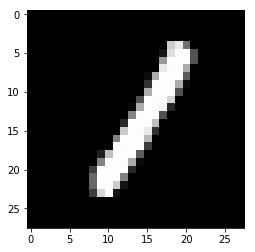

(1, array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))

In [4]:
# sample image
i = np.random.randint(len(X))
plt.imshow(X[i].reshape(28,28),cmap='gray')
plt.show()
np.argmax(y[i]),y[i]

### Model building

In [5]:
from keras.models import Model, Sequential
from keras.layers import Convolution2D, LeakyReLU, BatchNormalization, Flatten
from keras.layers import Dense, Input, Reshape, ReLU, Conv2DTranspose, Activation

Using TensorFlow backend.


In [6]:
input_layer = Input(shape = X[0].shape)
x = Convolution2D(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(input_layer)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = Convolution2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = LeakyReLU(0.2)(x)
x = Flatten()(x)
output = (Dense(1,activation='sigmoid'))(x)

discriminator = Model(inputs=input_layer,outputs=output)
discriminator.compile(optimizer='adam',loss='binary_crossentropy')

discriminator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv

In [10]:
input_layer = Input(shape=(1,1,100))
x = Dense(2048)(input_layer)
x = Reshape(target_shape=(4, 4, 128))(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same', output_padding=(0,0))(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
x = ReLU()(x)
x = Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=(2, 2), padding='same')(x)
x = BatchNormalization(momentum=0.5)(x)
output = Activation('tanh')(x)

generator = Model(inputs = input_layer,outputs = output)
generator.compile(optimizer='adam',loss='binary_crossentropy')
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 1, 100)         0         
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1, 2048)        206848    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 128)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 7, 7, 64)          204864    
_________________________________________________________________
batch_normalization_8 (Batch (None, 7, 7, 64)          256       
__________

In [11]:
discriminator.predict(X[:10])

array([[0.4988991 ],
       [0.50003064],
       [0.5075602 ],
       [0.50134796],
       [0.49662948],
       [0.5094825 ],
       [0.49886936],
       [0.5010342 ],
       [0.501088  ],
       [0.5033262 ]], dtype=float32)

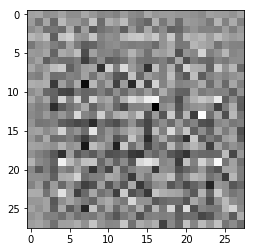

In [13]:
# sample generate image (before training)
z = np.random.normal(size=(1,1,1,100))

im = generator.predict(z)

plt.imshow(im[0].reshape(28,28),cmap='gray')
plt.show()

In [14]:
gan = Sequential()
discriminator.trainable = False
gan.add(generator)
gan.add(discriminator)

gan.compile(optimizer='adam',loss='binary_crossentropy')

gan.predict(z)

array([[0.50038683]], dtype=float32)

### Training

In [15]:
# take a subset of MNIST to make the training faster
X_copy = X.copy()
mask = np.random.choice(range(len(X)),size=2000)
X = X[mask]

In [16]:
epochs = 200
print_fq = 20
batch_size = 100
generator_ratio = 2

for epoch in range(epochs):
    if ((epoch+1)%print_fq==0):
        print('Epoch: ',epoch+1)
    for batch in range(len(X)//batch_size):
        # normalize data to -1, 1 (works better that way, also in line with tanh output of generator)
        x_b = X[batch*batch_size:(batch+1)*batch_size]*2-1
        y_b = y[batch*batch_size:(batch+1)*batch_size]
        # randomly generate latent values
        z = np.random.normal(size=((len(x_b),)+(1,1,100)))
        images = generator.predict(z)
        # generate labels for discriminator
        real = np.ones(len(x_b)) - np.random.random(size=len(x_b))*0.2
        fake = np.zeros(len(x_b)) + np.random.random(size=len(x_b))*0.2
        
        # train discriminator once
        discriminator.trainable = True
        discriminator.train_on_batch(x_b,real)
        discriminator.train_on_batch(images,fake)
        
        # train generator n times
        for i in range(generator_ratio):
            discriminator.trainable = False
            # generate new images
            z = np.random.normal(size=((len(x_b),)+(1,1,100)))
            # discriminator should be fooled into accepting those images
            fool = np.ones(len(x_b)) - np.random.random(size=len(x_b))*0.2
            gan.train_on_batch(z,fool)

Instructions for updating:
Use tf.cast instead.
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80
Epoch:  100
Epoch:  120
Epoch:  140
Epoch:  160
Epoch:  180
Epoch:  200


### Generated images

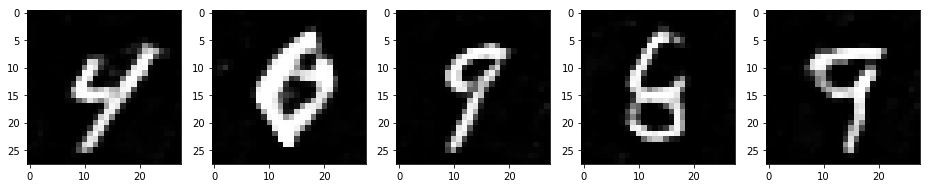

In [19]:
z = np.random.normal(size=(5,1,1,100))

im = generator.predict(z)

fig, ax = plt.subplots(ncols=5,figsize=(16,6))
for i in range(5):
    ax[i].imshow(im[i].reshape(28,28),cmap='gray')
plt.show()